### Домашнее задание <a class="anchor" id="hw"></a><center>

**1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).**

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

import warnings
warnings.filterwarnings('ignore')

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [2]:
# Устанавливает зерно для генератора случайных чисел библиотеки NumPy равным 42.
# Это необходимо для воспроизводимости случайных результатов.
# Установка одного и того же зерна гарантирует, что при каждом запуске программы
# будут получаться одни и те же случайные числа.
np.random.seed(42)

# Объявляется функция с именем get_bootstrap, которая принимает три аргумента:
# data, labels и N. data представляет собой массив данных, labels - массив меток,
# а N - количество "бутстрэп"-выборок, которые нужно создать.
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой

    # Создается пустой список bootstrap, в который будут добавляться "бутстрэп"-выборки.
    bootstrap = []

    # Начинается цикл, который будет выполняться N раз,
    # чтобы создать указанное количество "бутстрэп"-выборок.
    for i in range(N):
        
        # Для каждой "бутстрэп"-выборки генерируется случайный набор
        # индексов объектов из исходной выборки. Функция np.random.randint()
        # используется для генерации случайных целых чисел в указанном диапазоне.
        sample_index = np.random.randint(0, n_samples, size=n_samples)

        # Создается "бутстрэп"-выборка для данных, выбирая строки
        # из исходной выборки по сгенерированным случайным индексам.
        b_data = data[sample_index]

        # То же самое делается и для меток: создается "бутстрэп"-выборка меток,
        # соответствующих выбранным строкам данных.
        b_labels = labels[sample_index]
        
        # Сформированные "бутстрэп"-выборки данных и меток добавляются
        # в список bootstrap в виде кортежа (b_data, b_labels).
        bootstrap.append((b_data, b_labels))
    
    # По завершении цикла функция возвращает список "бутстрэп"-выборок.
    return bootstrap

In [3]:
# Объявляется функция с именем get_subsample, которая принимает
# один аргумент len_sample - это длина исходной выборки.
def get_subsample(len_sample):

    # Создается список sample_indexes, который содержит индексы элементов исходной выборки.
    # Функция range(len_sample) создает последовательность чисел от 0 до len_sample - 1,
    # а list() преобразует эту последовательность в список.
    sample_indexes = list(range(len_sample))

    # Вычисляется размер подвыборки (subsample) как квадратный корень из длины исходной выборки.
    # Такой подход часто используется для случайного выбора подмножества признаков.
    len_subsample = int(np.sqrt(len_sample))
    
    # Создается подвыборка (subsample) из индексов исходной выборки.
    # Функция np.random.choice() используется для случайного выбора
    # len_subsample индексов из списка sample_indexes.
    # Параметр replace=False означает, что выборка будет без повторений,
    # то есть каждый индекс будет выбран только один раз.
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    # Функция возвращает подвыборку в виде массива индексов.
    return subsample

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):

        # Атрибут self.data объекта класса Leaf устанавливается равным переданным данным.
        self.data = data

        # Атрибут self.labels объекта класса Leaf устанавливается равным переданным меткам.
        self.labels = labels

        # Вызывается метод predict() для прогнозирования класса листа на основе переданных меток.
        self.prediction = self.predict()
    
    # Метод predict, который используется для вычисления
    # прогноза класса на основе меток, хранящихся в листе.
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"

        # Начинается цикл по всем меткам в атрибуте self.labels листа.
        for label in self.labels:

            # Подсчитывается количество объектов каждого класса. Если метка label еще не встречалась,
            # она добавляется в словарь classes, и ее значение устанавливается на 0.
            # Затем значение этого класса увеличивается на 1.
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)

        # Метод возвращает прогноз класса, который является классом
        # с наибольшим количеством объектов в листе.
        return prediction        

In [6]:
# Расчет критерия Джини

# Здесь определяется функция с именем gini, которая принимает
# аргумент labels, предположительно, это массив меток.
def gini(labels):

    #  подсчет количества объектов разных классов
    classes = {}

    # Начинается цикл по всем меткам в переданных метках.
    for label in labels:

        # Подсчитывается количество объектов каждого класса. Если метка label еще не встречалась,
        # она добавляется в словарь classes, и ее значение устанавливается на 0.
        # Затем значение этого класса увеличивается на 1.
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    # Это начальное значение для расчета коэффициента неопределенности (Gini impurity).
    impurity = 1

    # Начинается цикл по всем классам в словаре classes.
    for label in classes:

        # Для каждого класса вычисляется вероятность (p), что объект принадлежит этому классу.
        # Затем вычитается квадрат этой вероятности из переменной impurity.
        # Это делается для каждого класса, и результат суммируется,
        # чтобы получить общий коэффициент неопределенности.
        p = classes[label] / len(labels)
        impurity -= p ** 2
    
    # Функция возвращает общий коэффициент неопределенности (Gini impurity),
    # который был вычислен для переданных меток.
    return impurity

In [7]:
# Расчет прироста

# Определяется функция с именем gain, которая принимает четыре аргумента:
# left_labels, right_labels, root_criterion и criterion.
# left_labels и right_labels - это метки объектов,
# попавших в левое и правое поддеревья соответственно,
# root_criterion - критерий неопределенности корня,
# а criterion - функция для вычисления критерия неопределенности.
def gain(left_labels, right_labels, root_criterion, criterion):

    # Вычисляется доля объектов, попавших в левое поддерево.
    # Это делается путем деления количества объектов в левом поддереве
    # на общее количество объектов в обоих поддеревьях.
    # left_labels.shape[0] возвращает количество объектов в массиве left_labels.
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    # Возвращает выигрыш (gain) при разделении на два поддерева.
    # Он вычисляется как разница между критерием неопределенности корня
    # и суммой взвешенных значений критерия неопределенности в левом и правом поддеревьях.
    # criterion(left_labels) и criterion(right_labels) вызывают функцию criterion
    # для расчета критерия неопределенности в левом и правом поддеревьях соответственно.
    # Веса соответствуют долям объектов в поддеревьях:
    # p для левого поддерева и 1 - p для правого.
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [8]:
# Разбиение датасета в узле

# Определяется функция с именем split, которая принимает четыре аргумента:
# data, labels, column_index и t. data и labels - это данные и соответствующие им метки,
# column_index - индекс столбца (признака), по которому будет производиться разделение,
# а t - пороговое значение для разделения данных.
def split(data, labels, column_index, t):
    
    # Происходит разделение данных на две части: "левую" и "правую".
    # С помощью np.where() находятся индексы элементов в массиве data,
    # где значение в столбце с индексом column_index
    # меньше или равно t для "левой" части и больше t для "правой" части.
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    # Создаются два набора данных: true_data содержит данные,
    # для которых значение в столбце column_index меньше или равно t,
    # а false_data содержит данные, для которых значение в этом столбце больше t.
    true_data = data[left]
    false_data = data[right]
    
    # Создаются два набора меток: true_labels содержит метки,
    # соответствующие данным из true_data,
    # а false_labels содержит метки для false_data.
    true_labels = labels[left]
    false_labels = labels[right]
    
    # Функция возвращает четыре набора данных и меток:
    # true_data, false_data, true_labels и false_labels,
    # которые представляют собой результат разделения исходных данных
    # по порогу t и столбцу с индексом column_index.
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    # Обозначим минимальное количество объектов в узле
    # Устанавливается минимальное количество объектов в листе.
    # Это значение будет использоваться для проверки,
    # достаточно ли маленькое разделение данных,
    # чтобы остановить процесс разделения.
    min_leaf_samples = 5

    # Вычисляется начальный коэффициент неопределенности (Gini impurity) для корня дерева.
    # Функция gini() вызывается для расчета коэффициента неопределенности на основе переданных меток.
    root_gini = gini(labels)

    # Инициализируются переменные для хранения лучшего выигрыша (gain),
    # порога (t) и индекса столбца (index) для разделения данных.
    best_gain = 0
    best_t = None
    best_index = None
    
    # Вычисляется количество признаков (столбцов) в данных.
    # data.shape[1] возвращает количество столбцов в массиве data.
    n_features = data.shape[1]
    
    # Генерируется случайная подвыборка индексов признаков.
    # Функция get_subsample() вызывается для получения этой подвыборки.
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    # Начинается цикл, в котором переменная index перебирает индексы признаков
    # из случайной подвыборки feature_subsample_indices.
    for index in feature_subsample_indices:

        # Вычисляются уникальные значения порогов для текущего признака index в массиве данных data.
        # Это позволит нам проверить различные пороги для разделения данных по данному признаку.
        t_values = np.unique(data[:, index])
        
        # Внутренний цикл перебирает все уникальные значения порогов t, полученные на предыдущем шаге.
        for t in t_values:

            # Для каждого значения порога t и индекса признака index данные разделяются на две части:
            # "истинную" (true_data, true_labels) и "ложную" (false_data, false_labels).
            # Функция split() используется для выполнения этого разделения.
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            # Проверяется, достигнуто ли минимальное количество объектов в каждом из поддеревьев,
            # полученных в результате разделения. Если это условие не выполняется, текущее разделение пропускается,
            # и происходит переход к следующему значению порога.
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            # Вычисляется текущий выигрыш (gain) при текущем разделении данных на две части.
            # Функция gain() используется для этого, принимая на вход метки для "истинной" и "ложной" частей,
            # а также начальный коэффициент неопределенности для корня дерева
            # и функцию для вычисления критерия неопределенности.
            current_gain = gain(true_labels, false_labels, root_gini, gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            # Если текущий выигрыш больше, чем лучший до этого момента,
            # то значения текущего выигрыша, порога и индекса признака
            # обновляются и записываются как лучшие до сих пор.
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    # Функция возвращает лучший выигрыш, порог и индекс столбца для разделения данных.
    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    # Вызывается функция find_best_split() для поиска лучшего
    # разделения данных data на основе меток labels.
    # Эта функция возвращает три значения: gain (выигрыш),
    # t (порог) и index (индекс признака), на котором производится разделение.
    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # Проверяется, равен ли выигрыш нулю. Если это так, то достигнута точка останова,
    # и возвращается объект Leaf, представляющий собой
    # лист дерева с данными data и метками labels.
    if gain == 0:
        return Leaf(data, labels)

    # Данные data и метки labels разделяются на две части
    # (true_data, false_data, true_labels, false_labels)
    # с использованием найденного порога t и индекса признака index.
    # Функция split() используется для этого разделения.
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно вызываются две новые ветви дерева (true_branch и false_branch),
    # которые строятся на основе разделенных данных true_data и false_data,
    # а также соответствующих им меток true_labels и false_labels.
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращается объект Node, который представляет собой узел дерева.
    # Узел содержит информацию о том, какой признак (index) был использован для разделения,
    # какой порог (t) был выбран, а также ссылки на дочерние ветви (true_branch и false_branch).
    return Node(index, t, true_branch, false_branch)

In [11]:
# Определяется функция с именем random_forest, которая принимает три аргумента:
# data (данные), labels (метки) и n_trees (количество деревьев в лесу).
def random_forest(data, labels, n_trees):

    # Создается пустой список forest, в который будут добавляться построенные деревья.
    forest = []

    # Генерируется набор "бутстрэп"-выборок (bootstrap) с помощью функции get_bootstrap().
    # Каждая "бутстрэп"-выборка представляет собой случайную подвыборку из исходных данных и меток.
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    # Начинается цикл, в котором b_data и b_labels перебираются по всем элементам в bootstrap.
    # Каждый элемент представляет собой пару "бутстрэп"-выборки данных и соответствующих меток.
    for b_data, b_labels in bootstrap:

        # Для каждой "бутстрэп"-выборки данных и меток вызывается функция build_tree(),
        # которая строит дерево решений на основе этих данных,
        # а затем полученное дерево добавляется в список forest.
        forest.append(build_tree(b_data, b_labels))
    
    # Функция завершается, возвращая построенный лес деревьев.
    # Каждый элемент в списке forest представляет собой дерево решений,
    # построенное на основе своей "бутстрэп"-выборки.
    return forest

In [12]:
# Функция классификации отдельного объекта

# Определение функции classify_object, которая принимает два аргумента:
# obj (объект, который мы классифицируем) и node (узел дерева, с которого начинается классификация).
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    # Проверяет, является ли узел node листом дерева.
    # Если да, значит, мы достигли конечного узла, и мы можем вернуть прогноз,
    # который хранится в этом листе (node.prediction),
    # так как нет необходимости проверять дальше.
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    # Сравнение значения признака объекта obj, индекс которого равен
    # индексу признака узла node.index, с порогом node.t, хранящимся в этом узле.
    if obj[node.index] <= node.t:

        # Если значение признака меньше или равно порогу,
        # то объект классифицируется по левой ветви дерева.
        # Для этого вызывается рекурсивно функция classify_object()
        # с аргументами obj (классифицируемый объект) и node.true_branch (левая ветвь узла).
        # Таким образом, процесс классификации продолжается для этой ветви дерева.
        return classify_object(obj, node.true_branch)
    
    # Если значение признака больше порога, то выполняется этот блок кода.
    else:

        # Объект классифицируется по правой ветви дерева.
        # Для этого также вызывается рекурсивно функция classify_object()
        # с аргументами obj и node.false_branch. Таким образом,
        # процесс классификации продолжается для правой ветви дерева.
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

# Определяется функция с именем predict, которая принимает два аргумента:
# data (данные, которые мы хотим классифицировать)
# и tree (дерево решений, по которому мы будем делать прогнозы).
def predict(data, tree):
    
    # Создается пустой список classes, в который будут добавляться
    # прогнозы для каждого объекта из data.
    classes = []

    # Начинается цикл, в котором переменная obj будет перебирать каждый объект из data.
    for obj in data:

        # Для каждого объекта вызывается функция classify_object(),
        # которая классифицирует этот объект, используя переданное дерево tree.
        # Полученный прогноз сохраняется в переменной prediction.
        prediction = classify_object(obj, tree)

        # Прогноз добавляется в список classes.
        classes.append(prediction)

    # После завершения цикла функция возвращает список classes,
    # содержащий прогнозы для каждого объекта из data.
    # Каждый элемент в списке представляет собой
    # прогноз для соответствующего объекта данных.
    return classes

In [14]:
# предсказание голосованием деревьев

# Определяется функция с именем tree_vote, которая принимает два аргумента:
# forest (лес деревьев решений) и data (данные, для которых мы хотим сделать прогнозы).
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    # Создается пустой список predictions, в который будут добавляться
    # прогнозы для каждого дерева из леса.
    predictions = []

    # Для каждого дерева из леса вызывается функция predict()
    # для получения прогнозов на основе данных data.
    # Полученные прогнозы добавляются в список predictions.
    for tree in forest:
        predictions.append(predict(data, tree))

    # сформируем список с предсказаниями для каждого объекта
    # Создается список predictions_per_object, который представляет собой
    # транспонированный список прогнозов. Это делается с помощью функции zip(*predictions),
    # которая превращает список прогнозов (по одному прогнозу на каждое дерево)
    # в список прогнозов для каждого объекта данных (по одному прогнозу на каждый объект).
    predictions_per_object = list(zip(*predictions))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    # Создается пустой список voted_predictions, в который будут
    # добавляться итоговые прогнозы, полученные путем голосования.
    voted_predictions = []

    # Для каждого объекта из списка predictions_per_object вычисляется прогноз методом голосования.
    # Для этого создается множество (set(obj)), содержащее уникальные прогнозы для данного объекта.
    # Затем функция max() находит наиболее часто встречающийся прогноз в множестве с помощью ключа obj.count,
    # который возвращает количество вхождений каждого элемента.
    # Этот прогноз добавляется в список voted_predictions.
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    
    # Функция завершается, возвращая список voted_predictions,
    # содержащий итоговые прогнозы для каждого объекта данных
    # на основе голосования всех деревьев в лесу.
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

# Определяется функция с именем accuracy_metric, которая принимает два аргумента:
# actual (фактические метки) и predicted (предсказанные метки).
def accuracy_metric(actual, predicted):

    # Создается переменная correct, которая будет использоваться
    # для подсчета количества правильных предсказаний.
    correct = 0

    # Начинается цикл, в котором переменная i будет перебирать индексы элементов в списке actual.
    for i in range(len(actual)):

        # Для каждой итерации цикла проверяется, совпадает ли
        # элемент i в списке actual с элементом i в списке predicted.
        # Если они совпадают, то значение переменной correct увеличивается на 1.
        if actual[i] == predicted[i]:
            correct += 1

    # После завершения цикла функция возвращает процент правильных предсказаний.
    # Для этого сначала вычисляется доля правильных предсказаний,
    # разделив количество правильных предсказаний correct
    # на общее количество элементов в списке actual.
    # Затем результат умножается на 100.0,
    # чтобы преобразовать его в процентное значение.
    return correct / float(len(actual)) * 100.0

In [16]:
# Вызывается функция make_classification(). Это функция, которая
# генерирует случайные данные для задачи классификации с управляемой разметкой.
# n_samples=1000 - общее количество сэмплов (наблюдений или объектов),
# которые будут сгенерированы. В данном случае генерируется 1000 сэмплов.
# n_features=2 - количество признаков в каждом сэмпле. Здесь у нас есть два признака.
# n_informative=2 - количество информативных признаков среди сгенерированных признаков.
# В данном случае у нас есть два информативных признака.
# n_classes=2 - количество классов, которые нужно сгенерировать. У нас есть два класса.
# n_redundant=0 - количество избыточных признаков среди сгенерированных признаков.
# Здесь нет избыточных признаков (их количество равно 0).
# n_clusters_per_class=1 - количество кластеров на класс в данных.
# В данном случае каждый класс содержит один кластер.
# random_state=3 - начальное значение для генератора случайных чисел.
# Устанавливая одинаковое значение random_state, мы гарантируем
# получение одинаковых данных при повторном запуске кода.
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=3)

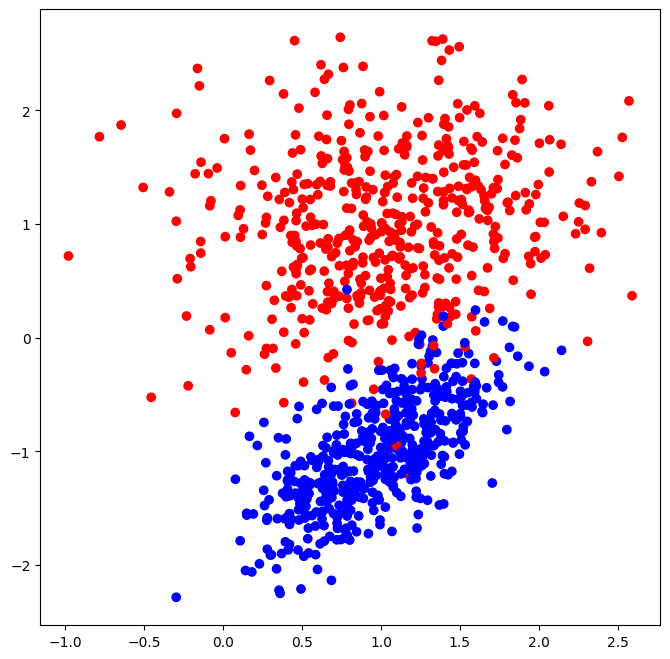

In [17]:
# визуализируем сгенерированные данные

# Создается объект colors класса ListedColormap из библиотеки matplotlib.colors.
# Этот объект определяет цвета, которые будут использоваться для отображения классов.
# В данном случае у нас два класса, поэтому используются красный и синий цвета.
colors = ListedColormap(['red', 'blue'])

# Создается объект light_colors класса ListedColormap, который определяет
# светлые версии цветов для отображения областей классов.
# Это нужно для подсветки границ между классами на графике.
light_colors = ListedColormap(['lightcoral', 'lightblue'])

# Создается новая фигура с помощью функции figure() из библиотеки
# matplotlib.pyplot (обычно импортируется как plt).
# Указывается размер фигуры (в данном случае 8 на 8 дюймов).
plt.figure(figsize=(8, 8))

# Строится точечная диаграмма (scatter plot). Функция scatter() принимает два аргумента:
# значения по оси x и значения по оси y. В данном случае
# classification_data[:, 0] - значения первого признака,
# а classification_data[:, 1] - значения второго признака для всех объектов.
# Цвет каждой точки определяется меткой класса объекта, которая передается в аргумент c
# и определяется с помощью цветовой карты (cmap=colors). Точки, относящиеся к разным классам,
# будут отображаться разными цветами. В конце строки ставится ;, чтобы предотвратить
# отображение объекта matplotlib.axes._subplots.AxesSubplot, который возвращает функция scatter().
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [18]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

# Вызывает функцию train_test_split, которая разделяет
# данные и метки на обучающие и тестовые наборы.
# classification_data - это данные для обучения модели.
# classification_labels - это метки для обучающих данных.
# test_size=0.3 - это аргумент, который определяет долю тестового набора.
# Здесь указано, что 30% данных будут использоваться в тестовом наборе,
# а оставшиеся 70% будут использоваться в обучающем наборе.
# random_state=1 - это аргумент, который задает начальное значение
# для генератора случайных чисел. Устанавливая его на константное значение,
# мы гарантируем, что при повторном запуске кода
# будут получаться одинаковые разбиения данных.
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [19]:
# Визуализируем дерево на графике

# Определяется функция с именем get_meshgrid, которая принимает три аргумента:
# data (данные для построения сетки), step (шаг сетки, по умолчанию 0.05)
# и border (ширина границы вокруг данных, по умолчанию 1.2).
def get_meshgrid(data, step=.05, border=1.2):

    # Вычисляются минимальные и максимальные значения по осям x и y с учетом границы.
    # Они используются для определения размеров сетки.
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border

    # Функция np.meshgrid() создает сетку координатных точек
    # на основе заданных массивов значений по осям x и y, с учетом шага.
    # Результатом являются два массива координатных точек, которые образуют сетку.
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, train_labels, test_data, test_labels, my_forest):

    # Создается новая фигура для графика с размером 16 на 7 дюймов.
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    # Создается первый subplot в фигуре. Это означает,
    # что мы разбиваем фигуру на одну строку и два столбца,
    # и текущий subplot будет первым.
    plt.subplot(1,2,1)

    # Получаем сетку координат для обучающих данных.
    xx, yy = get_meshgrid(train_data)

    # Получаем предсказания на сетке координат для каждой точки с помощью функции tree_vote.
    # xx.ravel() и yy.ravel() преобразуют двумерные массивы xx и yy в одномерные.
    # np.c_[] используется для конкатенации этих одномерных массивов
    # по оси вдоль второго измерения (по строкам).
    # Это создает массив точек с координатами x и y каждой точки на графике.
    # Функция tree_vote() принимает лес деревьев my_forest
    # и массив точек с координатами x и y. Она возвращает
    # предсказания для каждой точки на графике.
    # Полученные предсказания преобразуются в массив numpy.
    # Функция reshape(xx.shape) изменяет форму массива предсказаний так,
    # чтобы она соответствовала форме массива xx. То есть результаты предсказаний
    # для каждой точки на графике снова преобразуются в двумерный массив,
    # с теми же размерами, что и массив xx. Это необходимо
    # для корректного отображения результатов на графике.
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # Отображаем предсказания на сетке координат с помощью pcolormesh.
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)

    # Отображаем обучающие данные на графике,
    # где каждая точка окрашивается в соответствии с ее классом.
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    
    # Вычисляем точность модели на обучающем наборе данных.
    train_accuracy = accuracy_metric(train_labels, tree_vote(my_forest, train_data))
    
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    # Создаем второй subplot.
    plt.subplot(1,2,2)

    # Отображаем предсказания на сетке координат во втором subplot.
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)

    # Отображаем тестовые данные на графике во втором subplot.
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    
    # Вычисляем точность модели на тестовом наборе данных.
    test_accuracy = accuracy_metric(test_labels, tree_vote(my_forest, test_data))

    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [20]:
%%time
# Измеряет время выполнения всей ячейки кода.

# Устанавливается количество деревьев в лесу. В этом случае n_trees равно 1.
n_trees = 1

# Вызывается функция random_forest, которая создает случайный лес.
# Она принимает три аргумента: обучающие данные train_data,
# метки классов для обучающих данных train_labels и количество деревьев n_trees.
my_forest_1 = random_forest(train_data, train_labels, n_trees)

CPU times: total: 422 ms
Wall time: 446 ms


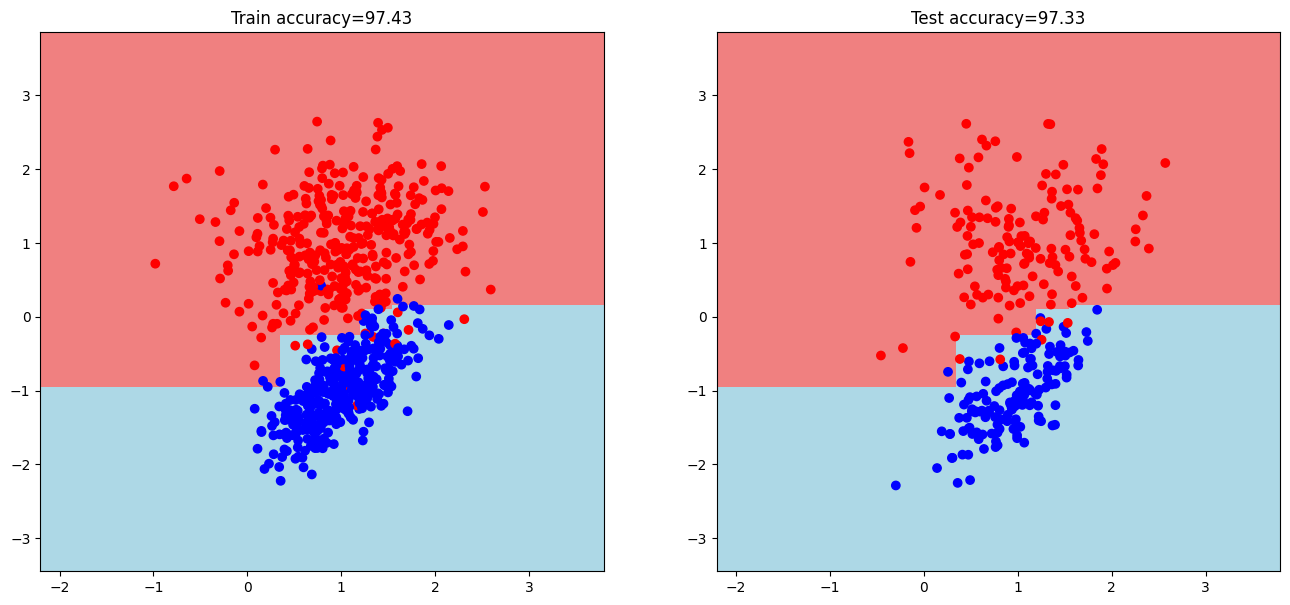

In [21]:
# Создает два графика: первый показывает обучающие данные с контурной картой,
# а второй - тестовые данные с контурной картой.
# Точность модели на обучающих и тестовых данных
# также отображается в заголовках графиков.
visualize(train_data, train_labels, test_data, test_labels, my_forest_1)

Построим лес из трех деревьев

CPU times: total: 1.58 s
Wall time: 1.59 s


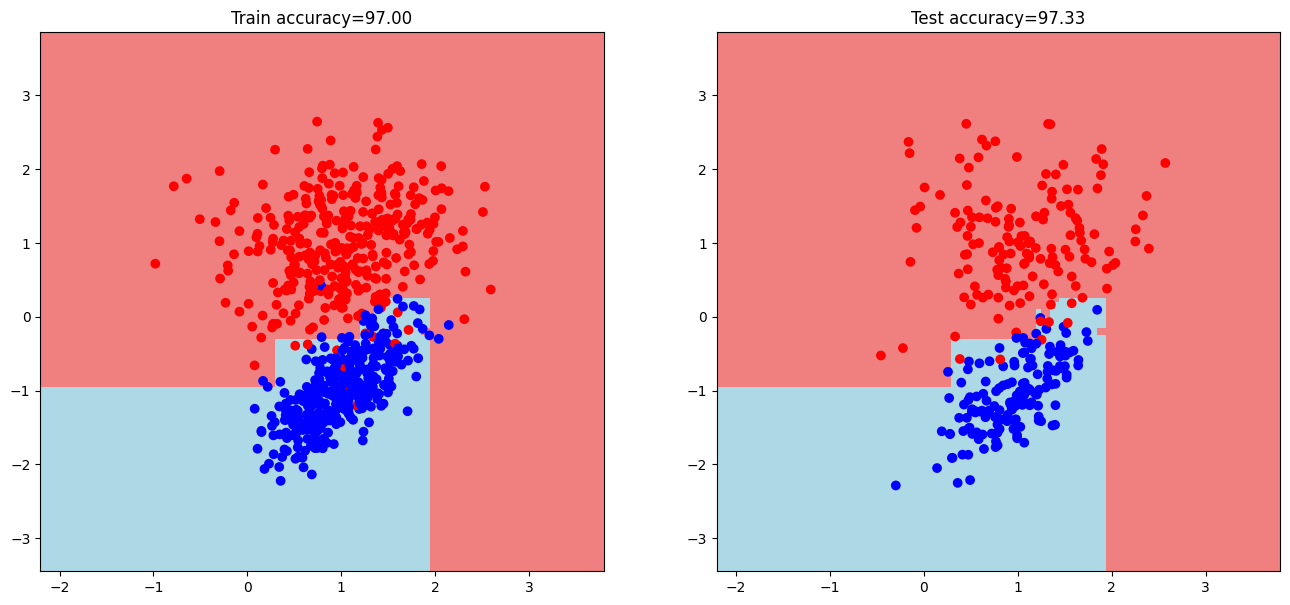

In [22]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)
visualize(train_data, train_labels, test_data, test_labels, my_forest_3)

Построим лес из десяти деревьев

CPU times: total: 4.19 s
Wall time: 4.22 s


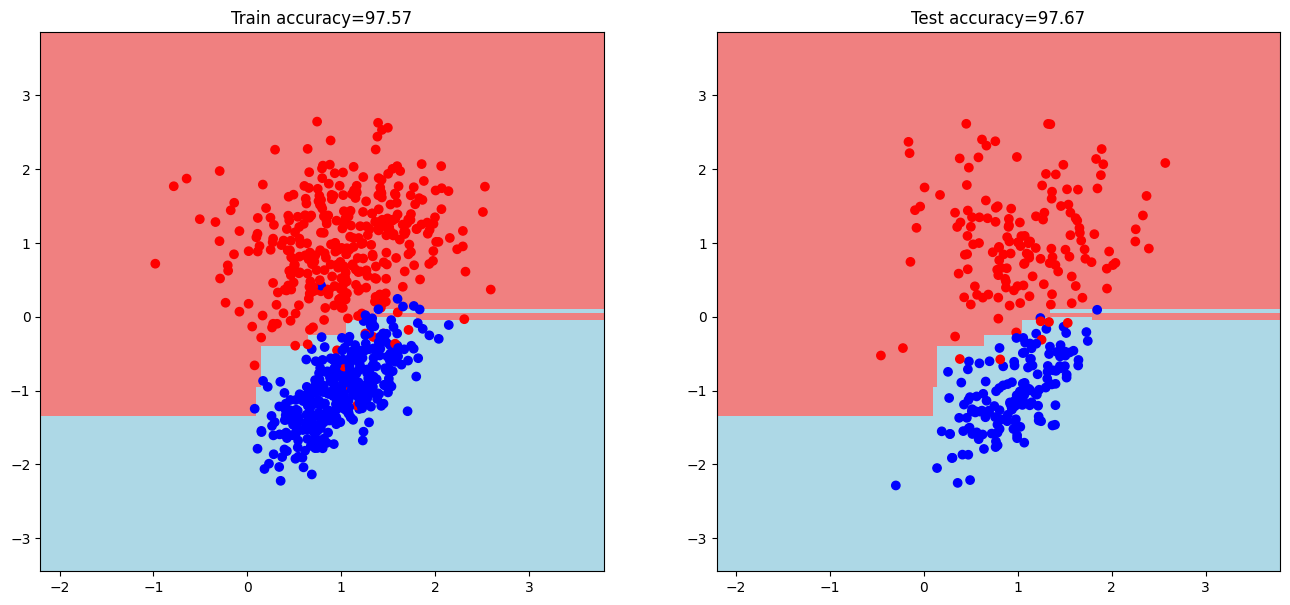

In [23]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)
visualize(train_data, train_labels, test_data, test_labels, my_forest_10)

Построим лес из пятидесяти деревьев

CPU times: total: 20.5 s
Wall time: 20.8 s


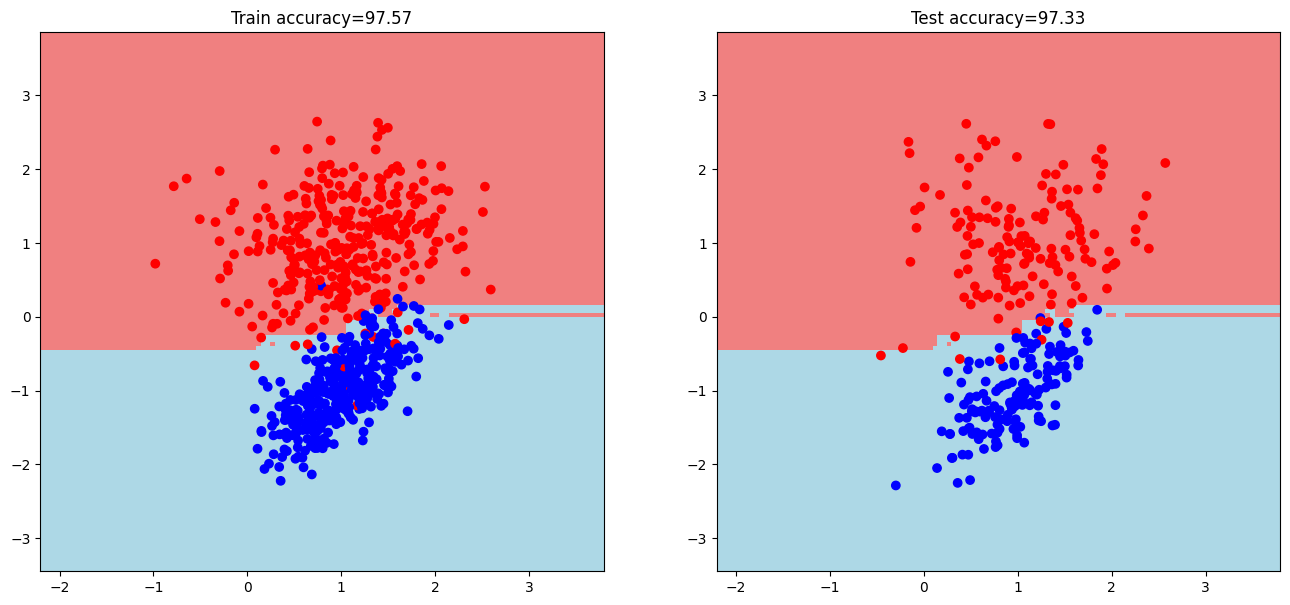

In [24]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)
visualize(train_data, train_labels, test_data, test_labels, my_forest_50)

**2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.**

In [25]:
# Используется для создания красивых прогресс-баров в циклах.
from tqdm import tqdm

# Создаются два пустых списка train_accs и test_accs,
# которые будут использоваться для хранения точности модели
# на обучающем и тестовом наборах данных соответственно.
train_accs = []
test_accs = []

# Этот цикл выполняется 50 раз для значений i от 1 до 50
# с использованием функции tqdm для создания прогресс-бара.
for i in tqdm(range(1, 51)):

    # В каждой итерации цикла создается новый случайный лес my_forest
    # с помощью функции random_forest, где n_trees равно текущему значению i.
    my_forest = random_forest(train_data, train_labels, n_trees=i)

    # Вычисляется точность модели на обучающем наборе данных с помощью
    # функции accuracy_metric, и это значение добавляется в список train_accs.
    train_accs.append(accuracy_metric(train_labels, tree_vote(my_forest, train_data)))

    # Аналогично для тестового набора данных: вычисляется точность модели
    # на тестовом наборе данных с помощью функции accuracy_metric,
    # и это значение добавляется в список test_accs.
    test_accs.append(accuracy_metric(test_labels, tree_vote(my_forest, test_data)))

# Этот код выполняет обучение случайного леса с разным количеством деревьев от 1 до 50
# и сохраняет точности на обучающем и тестовом наборах данных
# для каждого значения количества деревьев.

100%|██████████| 50/50 [08:16<00:00,  9.93s/it]


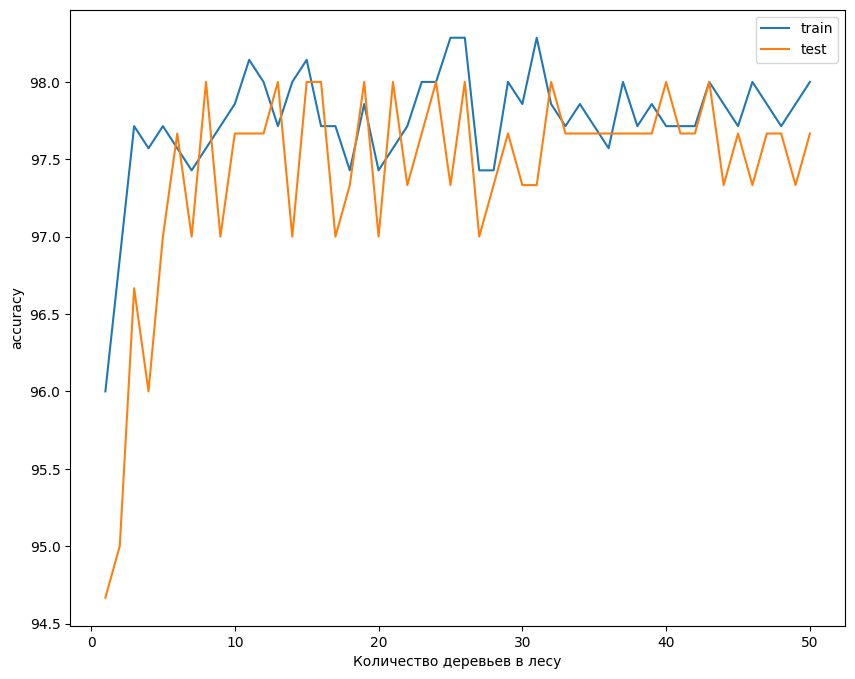

In [26]:
plt.figure(figsize=(10, 8))

# Строится график точности модели на обучающем наборе данных.
# range(1, 51) используется для оси x, чтобы значения были от 1 до 50.
# train_accs содержит значения точности модели на обучающем наборе данных
# для каждого количества деревьев от 1 до 50.
# Параметр label='train' задает подпись для линии графика,
# чтобы отразить, что это обучающий набор данных.
plt.plot(range(1, 51), train_accs, label='train')

# Строится график точности модели на тестовом наборе данных.
# range(1, 51) используется для оси x, чтобы значения были от 1 до 50,
# также как и для графика обучающего набора данных.
# test_accs содержит значения точности модели на тестовом наборе данных
# для каждого количества деревьев от 1 до 50.
# Параметр label='test' задает подпись для линии графика,
# чтобы отразить, что это тестовый набор данных.
plt.plot(range(1, 51), test_accs, label='test')

plt.xlabel('Количество деревьев в лесу')
plt.ylabel('accuracy')
plt.legend();

При увеличении количества деревьев получается более сложная гиперплоскость.

**3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.**

### Out-of-Bag

Вспомним, что каждое дерево $b_{n}$, составляющее случайный лес, строится на основе бутстрапированной выборки $X_{n}$. При этом примерно 37% объектов не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, это и называется _out-of-bag error_. Для каждогo объекта $x_{i}$ мы можем найти деревья, которые на нем не обучались, и вычислить ошибку: она рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

In [ ]:
10 obj, 5 trees
0 - 1 -> 0, 2 -> 0  -> 0  0
1 - 0 -> 1, 1 -> 0  -> 0  1
2 - 4 -> 0, 5 -> 0  -> 0  0
3 - 1 -> 0
4 - 
5
6
7
8
9

При использовании этого метода оценивания качества исчезает необходимость использовать отложенные выборки и кросс-валидацию при обучении случайных лесов.

In [27]:
# Устанавливает seed для генератора случайных чисел библиотеки NumPy.
# Установка seed обеспечивает воспроизводимость случайных результатов.
np.random.seed(42)

def get_oob_indices(sample_indices):

    # Создается массив индексов от 0 до длины sample_indices.
    indices = np.arange(len(sample_indices))

    # Возвращается массив индексов, которые не входят в sample_indices.
    # np.isin() используется для проверки принадлежности каждого индекса
    # из indices к массиву sample_indices, а ~ используется
    # для инвертирования результатов, чтобы получить индексы,
    # не принадлежащие к sample_indices.
    return indices[~np.isin(indices, sample_indices)]

# Определяет функцию с именем get_bootstrap, которая принимает три аргумента:
# data (матрица данных), labels (метки классов)
# и N (количество выборок для создания bootstrap).
def get_bootstrap(data, labels, N):

    # Вычисляется количество образцов в данных.
    n_samples = data.shape[0] # размер совпадает с исходной выборкой

    # Создается пустой список для хранения данных bootstrap
    # и соответствующих индексов out-of-bag (OOB).
    bootstrap_oob = []
    
    # Начинается цикл, который повторяется N раз.
    for i in range(N):
        
        # Создается случайная выборка индексов из диапазона от 0
        # до n_samples (не включительно) размером n_samples.
        # Это одна из выборок bootstrap.
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        
        # Выбираются данные и метки классов, соответствующие индексам из выборки sample_index.
        b_data = data[sample_index]
        b_labels = labels[sample_index]

        # Вычисляются индексы out-of-bag (OOB)
        # для текущей выборки bootstrap с помощью функции get_oob_indices.
        oob_indices = get_oob_indices(sample_index)
        
        # Каждая выборка bootstrap и ее соответствующие индексы OOB
        # добавляются в список bootstrap_oob.
        bootstrap_oob.append((b_data, b_labels, oob_indices))        
    
    # Возвращается список выборок bootstrap и соответствующих им индексов OOB.
    return bootstrap_oob

In [28]:
# Вызывается функция get_bootstrap с тремя аргументами:
# train_data (обучающие данные), train_labels (метки классов для обучающих данных)
# и 1 (количество выборок bootstrap для создания).
# Результат сохраняется в переменную b.
b = get_bootstrap(train_data, train_labels, 1)

# Вычисляется процент объектов out-of-bag (OOB) относительно общего числа объектов в выборке bootstrap.
# Количество объектов OOB (числитель) делится на общее количество объектов в выборке bootstrap (знаменатель),
# и результат умножается на 100, чтобы получить процентное значение.
b[0][2].shape[0] * 100 / b[0][0].shape[0]
# b[0][2].shape[0] - Извлекается третий элемент из первой выборки bootstrap b[0],
# который представляет собой индексы out-of-bag (OOB), а затем вызывается метод shape[0],
# чтобы узнать количество элементов в этом массиве. Это количество объектов OOB.
# b[0][0].shape[0] - Извлекается первый элемент из первой выборки bootstrap b[0],
# который представляет собой сами данные (обучающие данные), а затем вызывается метод shape[0],
# чтобы узнать количество элементов в этом массиве. Это количество объектов в выборке bootstrap.

38.857142857142854

In [29]:
np.zeros((10, len(set(classification_labels))))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [30]:
# Определяет функцию predict_oob, которая принимает четыре аргумента:
# oob_predictions (матрица предсказаний out-of-bag для каждого класса),
# oob_indices (индексы out-of-bag), tree (дерево решений) и data (все данные).
def predict_oob(oob_predictions, oob_indices, tree, data):

    # Создается массив oob_data, содержащий данные, соответствующие индексам out-of-bag.
    oob_data = data[oob_indices]

    # Вызывается функция predict для получения предсказаний
    # на данных out-of-bag с использованием дерева tree.
    prediction = predict(oob_data, tree)
    
    for i in range(len(oob_indices)):

        # Обновляются предсказания out-of-bag в матрице oob_predictions.
        # Для каждого индекса i из oob_indices увеличивается счетчик предсказаний
        # для соответствующего класса prediction[i] на 1.
        oob_predictions[oob_indices[i], prediction[i]] += 1

    # Функция возвращает обновленную матрицу предсказаний out-of-bag.
    return oob_predictions

# Определяет функцию random_forest_oob, которая принимает три аргумента:
# data (матрица данных), labels (метки классов)
# и n_trees (количество деревьев в случайном лесе).    
def random_forest_oob(data, labels, n_trees):

    # Создается пустой список forest для хранения деревьев решений.
    # Затем создается матрица oob_predictions, инициализированная нулями,
    # размер которой равен количеству объектов в данных и количеству уникальных классов.
    # Затем вызывается функция get_bootstrap для создания выборок bootstrap.
    forest = []
    oob_predictions = np.zeros((data.shape[0], len(set(labels))))
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    # Для каждой выборки bootstrap создается дерево решений с помощью функции build_tree,
    # которое добавляется в список forest. Затем вызывается функция predict_oob,
    # чтобы обновить предсказания out-of-bag в матрице oob_predictions.
    for b_data, b_labels, oob_indices in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
        oob_predictions = predict_oob(oob_predictions=oob_predictions,
                                      oob_indices=oob_indices,
                                      tree=tree,
                                      data=data)
#     print(oob_predictions)

    # Вычисляется оценка out-of-bag (OOB) с помощью функции accuracy_metric,
    # где сравниваются метки классов labels с метками, предсказанными по индексу класса
    # с максимальной вероятностью в oob_predictions.
    oob_score = accuracy_metric(labels, np.argmax(oob_predictions, axis=1))
    
    # Функция возвращает список деревьев forest и оценку out-of-bag (OOB) oob_score.
    return forest, oob_score

In [31]:
# Вызывается функция random_forest_oob с тремя аргументами:
# classification_data (данные для классификации), classification_labels (метки классов)
# и 5 (количество деревьев в случайном лесе). Результат этой функции
# присваивается переменным forest и oob_score.
forest, oob_score = random_forest_oob(classification_data, classification_labels, 5)
oob_score

90.9

In [32]:
# Импортирует класс RandomForestClassifier из модуля sklearn.ensemble,
# который предоставляет реализацию случайного леса для классификации.
from sklearn.ensemble import RandomForestClassifier

# Создается экземпляр класса RandomForestClassifier с двумя параметрами: oob_score=True и n_estimators=5.
# oob_score=True указывает, что оценка out-of-bag (OOB) должна быть вычислена после обучения модели.
# n_estimators=5 указывает количество деревьев в случайном лесе.
rf = RandomForestClassifier(oob_score=True, n_estimators=5)

# Вызывается метод fit, который обучает случайный лес
# на предоставленных данных classification_data
# и метках классов classification_labels.
rf.fit(classification_data, classification_labels)

# Возвращается оценка out-of-bag (OOB), вычисленная после обучения случайного леса.
# Это атрибут oob_score_ экземпляра RandomForestClassifier.
rf.oob_score_

# Этот код создает и обучает модель случайного леса с использованием библиотеки scikit-learn
# и затем выводит оценку out-of-bag (OOB), которая автоматически вычисляется
# при обучении модели с установленным параметром oob_score=True.

0.897